# Testing Deferred Revenue in Python
Will this be easier for everyone to use than Matlab?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Processing Base Billings Data

In [2]:
df = pd.read_excel('../data/old/base_billings.xlsx', sheet_name='bill_DC')

In [3]:
df.sample(10)

Document Currency     Enterprise Bu Frequency  \
1324                AUD    Document Cloud       NaN   
22266               SEK          Creative       NaN   
27250               USD  Experience Cloud      ONGO   
3688                BRL    Document Cloud       NaN   
24641               USD          Creative      ONGO   
4412                CAD  Experience Cloud      ONGO   
8237                EUR          Creative       NaN   
2656                AUD  Experience Cloud      ONGO   
16323               GBP  Experience Cloud      1TME   
15058               GBP  Experience Cloud      1TME   

      Invoicing Fiscal Year-Period Desc Product Configtype ID  \
1324                            2017-11                    1Y   
22266                           2016-04                 MTHLY   
27250                           2015-11                 ONORE   
3688                            2019-03                 MTHLY   
24641                           2017-04                 ONORE   
4412                            2018-04                   NaN   
8237                            2016-04                  IDRT   
2656                            2018-06                    1Y   
16323                           2019-01                    1Y   
15058                           2015-10                    1Y   

      Revenue Recognition Category New Rule For Bill Date  Sales Type  \
1324                                 D                 YA    DEFERRED   
22266                                A                NaN    DEFERRED   
27250                              NaN                NaN    DEFERRED   
3688                                 D                NaN    DEFERRED   
24641                              NaN                NaN  RECOGNIZED   
4412                                 D                 YQ    DEFERRED   
8237                               NaN                NaN  RECOGNIZED   
2656                                 D                 YQ    DEFERRED   
16323                                A                NaN    DEFERRED   
15058                                A                NaN    DEFERRED   

       Subscription Term  Completed Sales Doc Currency  
1324                   0                      64629.95  
22266                  1                     -16297.39  
27250                  0                          0.00  
3688                   1                       -345.00  
24641                  0                       4325.58  
4412                   0                      29592.31  
8237                   0                      94495.00  
2656                  12                     371904.51  
16323                  0                     214302.65  
15058                  0                      82144.52

## Changing the column names early since they are inconsistent across other reports

In [4]:
df.columns

Index(['Document Currency', 'Enterprise Bu', 'Frequency',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Revenue Recognition Category New', 'Rule For Bill Date', 'Sales Type',
       'Subscription Term', 'Completed Sales Doc Currency'],
      dtype='object')

In [5]:
df.rename(index = str, columns = {'Document Currency': 'curr',
                                 'Enterprise Bu': 'BU',
                                 'Invoicing Fiscal Year-Period Desc': 'period',
                                 'Product Configtype ID': 'config',
                                 'Rule For Bill Date': 'rebill_rule',
                                 'Completed Sales Doc Currency': 'amount'}, inplace=True)

In [6]:
df.columns

Index(['curr', 'BU', 'Frequency', 'period', 'config',
       'Revenue Recognition Category New', 'rebill_rule', 'Sales Type',
       'Subscription Term', 'amount'],
      dtype='object')

## Filter that removes any currency that has  < 10 transactions. 


In [11]:
# creates a list of the currencies and the number of transactions for each currency
vc = df['curr'].value_counts()
print(vc)

USD    7791
EUR    5291
GBP    3917
AUD    3500
JPY    3202
CHF    1678
SEK    1492
DKK    1455
NOK    1307
CAD    1109
HKD     231
RUB     199
BRL     184
NZD      38
SGD      12
KRW      12
Name: curr, dtype: int64


In [12]:
# Create variable that is true if the number of transaction is greater than 10, false otherwise
keep_these = vc.values > 10
# filtering only currencies that were greater than 10
keep_curr = vc[keep_these]
a = keep_curr.index
# filtering the dataframe to remove any of teh currencies not in our list
df = df[df['curr'].isin(a)]

## Just keeping track of the currencies we removed in our model_dict data structure

In [13]:
remove_these = vc.values <= 10
model_dict = {'curr_removed': list(vc[remove_these].index)}
model_dict

{'curr_removed': []}

In [141]:
vc.index[3]

'AUD'

# Removing any of the values that are zero

In [14]:
print('This is the length of the dataframe before removing zeros: ', len(df))
df = df[df['amount']!=0]
print('This is the length of the dataframe after removing zeros: ', len(df))

This is the length of the dataframe before removing zeros:  31418
This is the length of the dataframe after removing zeros:  28896


In [15]:
df.sample(10)

curr                  BU Frequency   period config  \
24561  USD            Creative      1TME  2017-02  ONORE   
7839   DKK  Print & Publishing       NaN  2016-08    NaN   
26598  USD      Document Cloud       NaN  2018-11    NaN   
754    AUD            Creative       NaN  2018-11     1Y   
8148   EUR            Creative       NaN  2016-01    NaN   
23337  SEK    Experience Cloud      1TME  2018-06  ONORE   
12731  EUR  Print & Publishing       NaN  2016-08  MTHLY   
28068  USD    Experience Cloud      ONGO  2016-10     1Y   
6519   DKK            Creative       NaN  2015-08     1Y   
4702   CAD  Print & Publishing       NaN  2017-04     1Y   

      Revenue Recognition Category New rebill_rule  Sales Type  \
24561                              NaN         NaN  RECOGNIZED   
7839                               NaN         NaN  RECOGNIZED   
26598                                D         NaN    DEFERRED   
754                                  A         NaN    DEFERRED   
8148                                 D          YA    DEFERRED   
23337                              NaN         NaN  RECOGNIZED   
12731                                D          Y3    DEFERRED   
28068                                D          Y1    DEFERRED   
6519                                 A         NaN    DEFERRED   
4702                                 A         NaN    DEFERRED   

       Subscription Term      amount  
24561                  0      936.60  
7839                   0     3450.00  
26598                  1      -28.97  
754                   12  2914734.21  
8148                  12      -89.42  
23337                  0     9853.82  
12731                  1      168.94  
28068                  0   -81434.73  
6519                   1   -10974.87  
4702                   0    16750.00

## Clearing out the Non-Revenue billings from the file
 - No Idea what these are

In [16]:
df['Sales Type'].value_counts()

DEFERRED       22919
RECOGNIZED      5041
PRO-SVC-INV      844
NON-REV           92
Name: Sales Type, dtype: int64

In [17]:
print('Length of the dataframe before removing non-revenue billings: ', len(df))
df = df[df['Sales Type']!='NON-REV']
print('Length of the dataframe after removing non-revenue billings:  ', len(df))


Length of the dataframe before removing non-revenue billings:  28896
Length of the dataframe after removing non-revenue billings:   28804


## Starting to group the revenue by period, industry, etc

Attempting to group by the following categories
 - currency
 - period
 - sale type
 
May need to process the data differently with the deferred billings so we will start with the recognized and then the service billings

# DOING THIS ALL IN PANDAS WITH SPLIT APPLY COMBINE on Sales Type 


In [18]:
# First split the data into three dataframes
# Recognized billings
rec = df[df['Sales Type']=='RECOGNIZED']
svc = df[df['Sales Type']=='PRO-SVC-INV']
dfr = df[df['Sales Type']=='DEFERRED']

In [19]:
rec.columns

Index(['curr', 'BU', 'Frequency', 'period', 'config',
       'Revenue Recognition Category New', 'rebill_rule', 'Sales Type',
       'Subscription Term', 'amount'],
      dtype='object')

# NOW WORKING ON THE BILLINGS

### Recognized Revenue

In [20]:
rec.sample(10)

curr                  BU Frequency   period config  \
16830  GBP  Print & Publishing       NaN  2017-03   IDRT   
17688  JPY            Creative       NaN  2016-07   IDRT   
11617  EUR    Experience Cloud      CERT  2018-03    NaN   
4526   CAD    Experience Cloud      ACTL  2018-11  ONORE   
20256  JPY  Print & Publishing       NaN  2016-01     2V   
22416  SEK            Creative       NaN  2017-10    NaN   
19432  JPY    Experience Cloud      ACTL  2017-02  ONORE   
6286   CHF           LiveCycle       NaN  2018-06    NaN   
7774   DKK     Other Solutions       NaN  2017-11    NaN   
17499  JPY            Creative       NaN  2015-11    NaN   

      Revenue Recognition Category New rebill_rule  Sales Type  \
16830                              NaN         NaN  RECOGNIZED   
17688                              NaN         NaN  RECOGNIZED   
11617                              NaN         NaN  RECOGNIZED   
4526                               NaN         NaN  RECOGNIZED   
20256                              NaN         NaN  RECOGNIZED   
22416                              NaN         NaN  RECOGNIZED   
19432                              NaN         NaN  RECOGNIZED   
6286                               NaN         NaN  RECOGNIZED   
7774                               NaN         NaN  RECOGNIZED   
17499                              NaN         NaN  RECOGNIZED   

       Subscription Term        amount  
16830                  0  3.040000e+03  
17688                  0  4.481600e+05  
11617                  0  3.436380e+05  
4526                   0  5.776373e+04  
20256                  0  6.075510e+05  
22416                  0  3.005820e+05  
19432                  0  2.815878e+07  
6286                   0  1.679000e+03  
7774                   0 -1.110000e+03  
17499                  0  1.528441e+08

In [21]:
# testing groupby object
gb_rec = rec.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [22]:
# the Subscription term hangs around. We are dropping that here
gb_rec.drop(labels='Subscription Term', axis=1,inplace =True)

In [23]:
gb_rec.sample(10)

curr                  BU   period       amount
753   EUR            Creative  2015-11   3182718.33
1299  HKD            Creative  2018-10      9238.00
523   CHF  Print & Publishing  2017-06      4451.00
1830  SEK      Document Cloud  2015-06    143860.00
1712  NOK     Other Solutions  2019-02       -68.75
1488  JPY     Other Solutions  2016-10   -714261.00
1437  JPY    Experience Cloud  2018-10  32906258.98
1205  GBP     Other Solutions  2015-10      -293.56
2295  USD  Print & Publishing  2018-10   3213718.08
264   CAD    Experience Cloud  2016-05      7903.88

In [24]:
print(type(gb_rec))

<class 'pandas.core.frame.DataFrame'>


## Now doing this for the service billings

In [25]:
# testing groupby object
gb_svc = svc.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [26]:
gb_svc.drop(labels='Subscription Term', axis=1,inplace =True)
gb_svc.head(5)

curr                BU   period      amount
0  AUD  Experience Cloud  2015-06   589499.45
1  AUD  Experience Cloud  2015-07   656493.50
2  AUD  Experience Cloud  2015-08   370780.74
3  AUD  Experience Cloud  2015-09  1251726.13
4  AUD  Experience Cloud  2015-10   291324.07

# NOW WORKING ON DEFERRED BILLINGS

## Type B billings are service agreements that will have invoices submitted before the billings are reclassified to revenue. If no invoices are assigned to the billings, the billings become revenue in 12 months

In [27]:
# filter out the type B first then do a group_by
dfr_b = dfr[dfr['Revenue Recognition Category New']=='B']

In [28]:
gb_b = dfr_b.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [29]:
gb_b.drop(labels='Subscription Term', axis=1, inplace=True)

In [30]:
gb_b.head(10)

curr                BU   period     amount
0  AUD          Creative  2017-10    8544.00
1  AUD    Document Cloud  2017-12    3283.20
2  AUD    Document Cloud  2018-06    3425.00
3  AUD    Document Cloud  2018-12    3425.00
4  AUD    Document Cloud  2019-03    4375.00
5  AUD  Experience Cloud  2015-06  258231.69
6  AUD  Experience Cloud  2015-07  261159.25
7  AUD  Experience Cloud  2015-08  270139.50
8  AUD  Experience Cloud  2015-09  482725.30
9  AUD  Experience Cloud  2015-10  287254.60

In [31]:
print('length of deferred billings : ', len(dfr))
print('length of the type B billings: ', len(dfr_b))

length of deferred billings :  22919
length of the type B billings:  997


## Now Type A Billings
These billings are on a billing plan. The product config tells us how long before they renew

 - '2Y' = 24 months
 - '1Y' = 12 months
 - 'MTHLY' = 1 month
 
NOTE: There are also other fields in the 'Product Configtype ID' field that do not map well to a rebill period.
To fix this, we need to load up a different file and determine the length of the sales contract (type A no config)
 

In [35]:
# filtering just the type A billings
dfr_a = dfr[dfr['Revenue Recognition Category New']=='A']

In [36]:
gb_a = dfr_a.groupby(['curr', 'BU', 'period',
                     'config'], as_index=False).sum()
gb_a.drop(labels='Subscription Term', axis=1, inplace = True)

In [37]:
gb_a.sample(10)

curr                BU   period config      amount
1428  EUR  Experience Cloud  2017-09     1Y  1773459.73
89    AUD          Creative  2017-12     1Y  4421875.61
1665  GBP          Creative  2016-05     1Y  2692218.06
2673  NOK    Document Cloud  2017-07  MTHLY     -856.00
959   DKK          Creative  2018-04     1Y    12614.57
2354  JPY    Document Cloud  2018-02  MTHLY   -50675.00
2816  SEK          Creative  2017-04     1Y   -50111.58
1005  DKK    Document Cloud  2016-11     1Y    -2855.02
542   CAD  Experience Cloud  2015-09     1Y    36989.60
93    AUD          Creative  2018-01     2Y       96.00

In [38]:
gb_a['config'].value_counts()

1Y       1856
MTHLY     823
2Y        657
OUNIV     171
OCONS      62
3Y         46
ONORE      28
Name: config, dtype: int64

### Below is just a check to see how large the billing types are across all periods

In [39]:
gb_a_config = gb_a.groupby(['config'], as_index=False).sum()
gb_a_config

config        amount
0     1Y  6.471612e+10
1     2Y  1.973660e+08
2     3Y  8.787511e+07
3  MTHLY -1.982427e+07
4  OCONS  2.883743e+07
5  ONORE  2.258881e+06
6  OUNIV  3.328696e+06

### These 'OCONS', 'ONORE' and 'OUNIV' data types are not actual product config IDs so we have to get them from a different data file. We are excluding these types below.

In [40]:
config_list = ['1Y', '2Y', '3Y', 'MTHLY']
test1 = gb_a['config'].isin(config_list)
sum(test1)

3382

In [41]:
test1 = gb_a[gb_a['config'].isin(config_list)]

## For now, lets just split this into gb_a_1Y, gb_a_2Y, gb_a_3y, gb_a_1M


In [42]:
gb_a_1Y = test1[test1['config']=='1Y']
gb_a_2Y = test1[test1['config']=='2Y']
gb_a_3Y = test1[test1['config']=='3Y']
gb_a_1M = test1[test1['config']=='MTHLY']

In [43]:
print('this is the lenght of type A 1M billings: ', len(gb_a_1M))
print('this is the lenght of type A 1Y billings: ', len(gb_a_1Y))
print('this is the lenght of type A 2Y billings: ', len(gb_a_2Y))
print('this is the lenght of type A 3Y billings: ', len(gb_a_3Y))

this is the lenght of type A 1M billings:  823
this is the lenght of type A 1Y billings:  1856
this is the lenght of type A 2Y billings:  657
this is the lenght of type A 3Y billings:  46


# TYPE D billings
These billings have a field 'Rule For Bill Date' that determines when new billings will occur
 - Monthly [Y1, Y2, Y3, Y5]
 - Quarterly [YQ]
 - Every 4 months [YT]
 - Semi-annual [YH]
 - Annual [YA, YC]
 - Every 2 years - [Y4]
 
 We also need to track the type D billings that do not have a 'Rule for Bill Date'

In [44]:
# for now just do a groupby on the type
# filtering just the type A billings
dfr_d = dfr[dfr['Revenue Recognition Category New']=='D']

In [45]:
gb_d = dfr_d.groupby(['curr', 'BU', 'period',
                     'rebill_rule'], as_index=False).sum()
gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [46]:
gb_d_mthly = gb_d[gb_d['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_d_qtrly = gb_d[gb_d['rebill_rule']=='YQ']
gb_d_four_mths = gb_d[gb_d['rebill_rule']=='YT']
gb_d_semi_ann = gb_d[gb_d['rebill_rule']=='YH']
gb_d_annual = gb_d[gb_d['rebill_rule'].isin(['YA', 'YC'])]
gb_d_two_yrs = gb_d[gb_d['rebill_rule']=='Y4']

In [47]:
gb_d['rebill_rule'].value_counts()

YA    1630
Y3    1438
YQ     530
Y1     256
YC     246
YH     243
Y2      95
Y4      23
Y7      18
YT       8
BT       1
Name: rebill_rule, dtype: int64

### Note: There is one type D billings that is listed as 'BT' I don't know what this means, but it was a $180 EUR payment from January 2017, so we will ignore

In [48]:
print('Length of monthly', len(gb_d_mthly))
print('Length of quarterly', len(gb_d_qtrly))
print('Length of four months', len(gb_d_four_mths))
print('Length of semi ann', len(gb_d_semi_ann))
print('Length of annual', len(gb_d_annual))
print('Length of two years', len(gb_d_two_yrs))

Length of monthly 1789
Length of quarterly 530
Length of four months 8
Length of semi ann 243
Length of annual 1876
Length of two years 23


In [50]:
what_is_YT = gb_d[gb_d['rebill_rule']=='YT']
what_is_YT.head(10)

curr                BU   period rebill_rule     amount
4054  USD  Experience Cloud  2015-06          YT   11666.60
4068  USD  Experience Cloud  2015-08          YT  549861.11
4081  USD  Experience Cloud  2015-10          YT   11666.60
4101  USD  Experience Cloud  2016-01          YT  612916.60
4106  USD  Experience Cloud  2016-02          YT -601250.00
4166  USD  Experience Cloud  2016-12          YT   13440.00
4190  USD  Experience Cloud  2017-04          YT   13440.00
4214  USD  Experience Cloud  2017-08          YT   13440.00

## Note: There are only 8 payments (back from 2017) that paid on a 4 month basis. 
We will ignore these as well.

## NOW WE NEED TO BUILD A DATAFRAME THAT INTEGRATES THIS DATA

- We will have the following descriptive fields
   - Invoicing Fiscal Year-Period
   - Document Currency
   - Enterprise BU

- We will have the following fields based on rebilling rule
   - Recognized
   - Service
   - Monthly
   - Quarterly
   - Annual
   - Two Years
   - Three Years

In [51]:
# We need to do it this way when we get to a .py file!
list_df = [gb_rec, gb_svc, gb_b,
        gb_a_1M,    gb_a_1Y,    gb_a_2Y,       gb_a_3Y, 
        gb_d_mthly, gb_d_qtrly, gb_d_semi_ann, gb_d_annual, gb_d_two_yrs]

list_columns = ['recognized', 'service', 'deferred_B', 
    'deferred_1M_a', 'deferred_1Y_a', 'deferred_2Y_a', 'deferred_3Y_a',
    'deferred_1M_d', 'deferred_3M_d', 'deferred_6M_d', 'deferred_1Y_d', 'deferred_2Y_d']


In [52]:
def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
    df_merged.rename(index=str, columns={'amount': new_column}, inplace=True)
    
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['config'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['rebill_rule'], inplace=True)
        
    return df_merged

In [53]:
def merge_all_dataframes(list_df, list_columns):
    for i, df in enumerate(list_df):
        print('This is i:', i)
        #print("This is the df: ", df.head())
        print('referencing the column: ', list_columns[i])

        if i==0:
            df_merged = list_df[0]
            df_merged.rename(index=str, columns={'amount': list_columns[i]}, inplace=True)
        else:
            df_merged = merge_new_dataframe(df_merged, df, list_columns[i])

    return df_merged
    

In [54]:
df = merge_all_dataframes(list_df, list_columns)

This is i: 0
referencing the column:  recognized
This is i: 1
referencing the column:  service
This is i: 2
referencing the column:  deferred_B
This is i: 3
referencing the column:  deferred_1M_a
This is i: 4
referencing the column:  deferred_1Y_a
This is i: 5
referencing the column:  deferred_2Y_a
This is i: 6
referencing the column:  deferred_3Y_a
This is i: 7
referencing the column:  deferred_1M_d
This is i: 8
referencing the column:  deferred_3M_d
This is i: 9
referencing the column:  deferred_6M_d
This is i: 10
referencing the column:  deferred_1Y_d
This is i: 11
referencing the column:  deferred_2Y_d


In [55]:
df.sample(10)

curr                  BU   period    recognized     service  deferred_B  \
1206  GBP            Creative  2018-08  1.820598e+05         NaN         NaN   
1541  JPY            Creative  2016-08  1.191013e+08         NaN         NaN   
38    AUD            Creative  2017-11  2.439450e+05         NaN         NaN   
2115  SEK      Document Cloud  2016-04  1.143200e+05         NaN         NaN   
2913  CAD            Creative  2016-04           NaN         NaN         NaN   
926   EUR    Experience Cloud  2016-09  7.096264e+06  1979795.81   843909.90   
910   EUR    Experience Cloud  2016-04  2.708426e+06  1437858.97   291737.29   
786   EUR            Creative  2015-10  2.796780e+06         NaN         NaN   
235   AUD  Print & Publishing  2016-03  1.234780e+05         NaN         NaN   
561   CHF  Print & Publishing  2017-11  1.355000e+03         NaN         NaN   

      deferred_1M_a  deferred_1Y_a  deferred_2Y_a  deferred_3Y_a  \
1206      -23478.04   6.406868e+06       12412.40            NaN   
1541     -947875.00   8.446353e+08            NaN            NaN   
38        -17592.54   3.202983e+06       23957.00            NaN   
2115        -180.00  -3.702700e+02            NaN            NaN   
2913            NaN   2.154762e+04            NaN            NaN   
926             NaN   9.031530e+05            NaN            NaN   
910             NaN   8.148884e+05            NaN            NaN   
786        -6750.51   1.258163e+07       57841.36            NaN   
235             NaN   1.414644e+05        3898.00            NaN   
561             NaN   1.650000e+01            NaN            NaN   

      deferred_1M_d  deferred_3M_d  deferred_6M_d  deferred_1Y_d  \
1206   1.245133e+07            NaN            NaN   2.450343e+06   
1541   8.571307e+08            NaN            NaN   2.831211e+08   
38     1.141227e+07            NaN            NaN   3.506321e+06   
2115   1.754060e+05            NaN            NaN   2.339018e+05   
2913            NaN            NaN            NaN   8.500808e+05   
926    2.793905e+05     1546921.52      224173.85   4.828113e+06   
910    7.119385e+04      708258.44       41042.75   1.122096e+06   
786    1.126182e+07            NaN       40000.00   4.126201e+06   
235    3.328535e+04            NaN            NaN   8.332372e+04   
561    3.968000e+03            NaN            NaN            NaN   

      deferred_2Y_d  
1206            NaN  
1541            NaN  
38              NaN  
2115            NaN  
2913            NaN  
926             NaN  
910             NaN  
786             NaN  
235             NaN  
561             NaN

In [56]:
def clean_df_columns(df):
    
    # clean up NaNs before adding 
    df = df.fillna(value=0)
    
    # Monthly
    df['deferred_1M'] = df['deferred_1M_a']+df['deferred_1M_d']
    df.drop(labels=['deferred_1M_a', 'deferred_1M_d'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y'] = df['deferred_1Y_a']+df['deferred_1Y_d']
    df.drop(labels=['deferred_1Y_a', 'deferred_1Y_d'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y'] = df['deferred_2Y_a']+df['deferred_2Y_d']
    df.drop(labels=['deferred_2Y_a', 'deferred_2Y_d'], axis=1, inplace=True)
    
    # renaming 3Y, 3M and 6M
    df.rename(index=str, columns = {'deferred_3Y_a':'deferred_3Y', 'deferred_3M_d':'deferred_3M', 
                               'deferred_6M_d': 'deferred_6M'}, inplace=True)

    #cleaning up the longer column names
    df.rename(index=str, columns = {'curr': 'curr',
                               'BU':'BU',
                               'period':'period'}, inplace=True)
    
    return df

In [57]:
df = clean_df_columns(df)

In [58]:
df.sample(10)

curr                BU   period    recognized     service  deferred_B  \
2658  USD  Experience Cloud  2018-02  7.396540e+06  7498637.74  7217760.65   
1497  HKD          Creative  2018-10  9.238000e+03        0.00        0.00   
2528  USD    Document Cloud  2018-05  1.576149e+07        0.00    27000.00   
1536  JPY          Creative  2016-06  1.138107e+08        0.00        0.00   
2966  CAD    Document Cloud  2017-10  0.000000e+00        0.00        0.00   
205   AUD         LiveCycle  2018-09  2.635100e+03        0.00        0.00   
216   AUD   Other Solutions  2018-08 -1.896200e+02        0.00        0.00   
1060  EUR         LiveCycle  2018-01  1.621800e+04        0.00        0.00   
1103  EUR   Other Solutions  2017-11 -3.445300e+03        0.00        0.00   
283   CAD          Creative  2015-09  3.104000e+02        0.00        0.00   

      deferred_3Y  deferred_3M  deferred_6M   deferred_1M   deferred_1Y  \
2658          0.0    6982123.4     814349.2  4.949273e+05  9.730955e+06   
1497          0.0          0.0          0.0  2.515298e+06  1.491841e+06   
2528          0.0     -82815.0       1687.8  3.458713e+06  2.222322e+07   
1536          0.0          0.0          0.0  1.066407e+09  2.007558e+09   
2966          0.0          0.0          0.0  0.000000e+00  8.922788e+04   
205           0.0          0.0          0.0  0.000000e+00  0.000000e+00   
216           0.0          0.0          0.0  0.000000e+00  0.000000e+00   
1060          0.0          0.0          0.0  0.000000e+00  8.685220e+04   
1103          0.0          0.0          0.0  0.000000e+00  0.000000e+00   
283           0.0          0.0          0.0  0.000000e+00  3.276782e+05   

      deferred_2Y  
2658          0.0  
1497          0.0  
2528     465559.0  
1536     696698.0  
2966          0.0  
205           0.0  
216           0.0  
1060          0.0  
1103          0.0  
283           0.0

In [59]:
# Make this a function to be cleaned up somehow
del dfr
del dfr_a
del dfr_b
del dfr_d
del gb_a
del gb_a_1M
del gb_a_1Y
del gb_a_2Y
del gb_a_3Y
del gb_b, 
del gb_d
del gb_svc, gb_rec, gb_d_two_yrs
del gb_d_four_mths, gb_d_qtrly, gb_d_semi_ann


# Now working on the ZCC billings

These billings are type D billings that did not populate the rebill_rule field of the database.

They have a 'sales document type' = 'ZCC"

The billings themselves are being created from a tableau report that looks for additions to the deferred revenue waterfall based on billings of type D and have a sales document type of ZCC

In [60]:
whos

Variable               Type         Data/Info
---------------------------------------------
a                      Index        Index(['USD', 'EUR', 'GBP<...>],\n      dtype='object')
clean_df_columns       function     <function clean_df_columns at 0x123490730>
config_list            list         n=4
df                     DataFrame         curr                <...>n[3116 rows x 12 columns]
gb_a_config            DataFrame      config        amount\n0<...>6\n6  OUNIV  3.328696e+06
gb_d_annual            DataFrame         curr                <...>\n[1876 rows x 5 columns]
gb_d_mthly             DataFrame         curr                <...>\n[1789 rows x 5 columns]
keep_curr              Series       USD    7791\nEUR    5291\<...>nName: curr, dtype: int64
keep_these             ndarray      16: 16 elems, type `bool`, 16 bytes
list_columns           list         n=12
list_df                list         n=12
merge_all_dataframes   function     <function merge_all_dataframes at 0x12126cae8>


In [61]:
df.sample(10)

curr                  BU   period   recognized     service  deferred_B  \
593   DKK            Creative  2016-10    111291.00         0.0         0.0   
370   CHF            Creative  2016-11     55952.00         0.0         0.0   
1390  GBP           LiveCycle  2018-02      1785.00         0.0         0.0   
732   DKK     Other Solutions  2016-10      -588.33         0.0         0.0   
3079  RUB      Document Cloud  2019-01         0.00         0.0         0.0   
2282  SEK  Print & Publishing  2017-05      9300.00         0.0         0.0   
1363  GBP           LiveCycle  2015-11      1094.00         0.0         0.0   
1694  JPY    Experience Cloud  2017-07  45438289.98  35018750.0  40821000.0   
1039  EUR           LiveCycle  2016-04     30595.71         0.0         0.0   
2357  USD            Creative  2016-05   8938710.91      5987.5     35690.0   

      deferred_3Y  deferred_3M  deferred_6M  deferred_1M  deferred_1Y  \
593           0.0         0.00          0.0   7306645.50   1380840.49   
370           0.0         0.00          0.0   1470341.62    560387.22   
1390          0.0         0.00          0.0         0.00         0.00   
732           0.0         0.00          0.0         0.00         0.00   
3079          0.0         0.00          0.0    401960.00    154878.00   
2282          0.0         0.00          0.0     31479.12         0.00   
1363          0.0         0.00          0.0         0.00     30255.98   
1694          0.0  15375000.00          0.0         0.00    962714.00   
1039          0.0         0.00          0.0         0.00    284256.83   
2357          0.0    106845.96     -53750.0  67466895.55  55581093.19   

      deferred_2Y  
593          0.00  
370          0.00  
1390         0.00  
732          0.00  
3079         0.00  
2282         0.00  
1363         0.00  
1694         0.00  
1039         0.00  
2357     28375.76

# TO BE DONE:

1. Clean up the type F billings (at least check to see if they are necessary)
2. Make a function to delete all intermediate dataframes
3. Add type A no config function
4. Add type D ZCC billings

5. Work on the forecast part of this

6. Load up FX rates

In [62]:
# Adobe financial calendar
df_cal = pd.read_excel('../data/old/ADOBE_FINANCIAL_CALENDAR.xlsx', 'ADBE_cal')

In [63]:
df_cal.head()

Year  Quarter  Period Qtr_Ticker  Qtr_Start    Qtr_End Per_Ticker  \
0  2010        1       1      Q1_10 2009-11-28 2010-03-05      P1_10   
1  2010        1       2      Q1_10 2009-11-28 2010-03-05      P2_10   
2  2010        1       3      Q1_10 2009-11-28 2010-03-05      P3_10   
3  2010        2       4      Q2_10 2010-03-06 2010-06-04      P4_10   
4  2010        2       5      Q2_10 2010-03-06 2010-06-04      P5_10   

   Per_Start    Per_End  
0 2009-11-28 2010-01-01  
1 2010-01-02 2010-01-29  
2 2010-01-30 2010-03-05  
3 2010-03-06 2010-04-02  
4 2010-04-03 2010-04-30

## ZCC Billings

In [64]:
df_ZCC = pd.read_excel('../data/old/type_D_ZCC_billings.xlsx', sheet_name='DC')

In [65]:
df_ZCC.sample(10)

Document Currency Enterprise BU Description Rev Rec Category  \
3131               JPY          Experience Cloud                D   
3694               USD          Experience Cloud                D   
3461               USD                  Creative                D   
3947               USD          Experience Cloud                D   
3863               USD          Experience Cloud                D   
3505               USD                  Creative                D   
3986               USD          Experience Cloud                D   
4291               USD          Experience Cloud                D   
1123               DKK          Experience Cloud                D   
113                AUD            Document Cloud                D   

     Rule for Bill Date Code Week of FICA Posting Date (YYYYMMDD) (copy)  \
3131                      YQ                                  2017-02-26   
3694                      Y1                                  2016-01-10   
3461                      YA                                  2019-01-06   
3947                      YA                                  2018-10-21   
3863                      Y3                                  2018-10-21   
3505                      YC                                  2018-12-23   
3986                      YA                                  2016-07-24   
4291                      YC                                  2018-05-27   
1123                      YH                                  2019-02-24   
113                       YA                                  2018-03-25   

      DF Additions - Doc Curr  
3131               3855300.00  
3694                  3436.00  
3461               2696222.02  
3947                 72855.96  
3863                  2500.00  
3505                147542.78  
3986                849014.70  
4291                257481.42  
1123                 91748.64  
113                  86030.84

### Renaming the columns

In [66]:
df_ZCC.columns

Index(['Document Currency', 'Enterprise BU Description', 'Rev Rec Category',
       'Rule for Bill Date Code',
       'Week of FICA Posting Date (YYYYMMDD) (copy)',
       'DF Additions - Doc Curr'],
      dtype='object')

In [67]:
df_ZCC.rename(index = str, columns = {'Document Currency': 'curr',
                                      'Enterprise BU Description':'BU',
                                      'Rule for Bill Date Code': 'rebill_rule',
                                      'Week of FICA Posting Date (YYYYMMDD) (copy)': 'fiscal_week',
                                      'DF Additions - Doc Curr': 'amount'}, inplace = True)

In [68]:
df_ZCC.columns

Index(['curr', 'BU', 'Rev Rec Category', 'rebill_rule', 'fiscal_week',
       'amount'],
      dtype='object')

### Checking that we do not have any currencies that need to be removed


In [69]:
df_ZCC['curr'].value_counts()

USD    1295
EUR     844
AUD     649
GBP     616
JPY     503
CAD     283
DKK     166
SEK     165
CHF     104
NOK      71
SGD       1
Name: curr, dtype: int64

In [70]:
model_dict

{'curr_removed': []}

In [71]:
ZCC_curr = df_ZCC['curr'].unique()

In [72]:
for item in ZCC_curr:
    if item in model_dict['curr_removed']:
        print('This currency needs to be removed: ', item)

There are no currencies that need to be removed

# Now we are clearing out nans

In [73]:
print('Number of NaNs to be cleared out: ', sum(df_ZCC['amount'].isna()))
ZCC_isna = df_ZCC['amount'].isna()
print("This is the length of the ZCC records before clearing NAs: ", len(df_ZCC))
df_ZCC = df_ZCC[~ZCC_isna]
print("This is the length of the ZCC records before clearing NAs: ", len(df_ZCC))

Number of NaNs to be cleared out:  34
This is the length of the ZCC records before clearing NAs:  4697
This is the length of the ZCC records before clearing NAs:  4663


In [74]:
df_cal.sample(5)

Year  Quarter  Period Qtr_Ticker  Qtr_Start    Qtr_End Per_Ticker  \
105  2018        4      10      Q4_18 2018-09-01 2018-11-30     P10_18   
218  2028        1       3      Q1_28 2027-12-04 2028-03-03      P3_28   
96   2018        1       1      Q1_18 2017-12-02 2018-03-02      P1_18   
196  2026        2       5      Q2_26 2026-02-28 2026-05-29      P5_26   
46   2013        4      11      Q4_13 2013-08-31 2013-11-29     P11_13   

     Per_Start    Per_End  
105 2018-09-01 2018-09-28  
218 2028-01-29 2028-03-03  
96  2017-12-02 2017-12-29  
196 2026-03-28 2026-04-24  
46  2013-09-28 2013-10-25

In [75]:
df_ZCC.sample(10)

curr                BU Rev Rec Category rebill_rule fiscal_week  \
3766  USD  Experience Cloud                D          Y1  2018-04-22   
2598  GBP  Experience Cloud                D          YQ  2017-07-02   
3962  USD  Experience Cloud                D          YA  2017-12-24   
3178  NOK  Experience Cloud                D          YA  2019-01-20   
4349  USD  Experience Cloud                D          YH  2019-01-20   
562   AUD  Experience Cloud                D          YQ  2016-05-01   
2822  JPY  Experience Cloud                D          Y1  2017-04-16   
3716  USD  Experience Cloud                D          Y1  2015-12-06   
4255  USD  Experience Cloud                D          YC  2016-09-25   
492   AUD  Experience Cloud                D          YQ  2017-03-19   

         amount  
3766  143092.65  
2598  166705.80  
3962  329319.32  
3178  281495.00  
4349   26784.00  
562    83074.72  
2822  -16000.00  
3716   16532.30  
4255   60000.00  
492    13750.00

In [76]:
def add_ZCC_periods(df_ZCC, df_cal):
    ''' 
    Takes each ZCC period billing and maps it to the fiscal calendar then assignes the
    ZCC billing to the dataframe df
    '''
    period_list = []
    
    for i in range(len(df_ZCC)):
        # this_date is the date we need mapped to a period
        this_date = df_ZCC['fiscal_week'].iloc[i]
        
        #max index will be the index to the period in our financial calendar
        this_index = df_cal['Per_End']<=this_date
        max_index = sum(this_index)

        this_year = df_cal['Year'].iloc[max_index].astype(str)
        this_period= df_cal['Period'].iloc[max_index].astype(str)

        # formatting the period string from the calendar
        if len(this_period)== 1:
            this_period = '0'+this_period

        period_ticker = this_year + '-' + this_period

        period_list.append(period_ticker)

    df_ZCC['period'] = period_list
    return df_ZCC


In [77]:
df_ZCC.head()

curr        BU Rev Rec Category rebill_rule fiscal_week    amount
1  AUD  Creative                D          YA  2017-07-16   2070.00
2  AUD  Creative                D          YA  2017-05-28   4560.00
3  AUD  Creative                D          YA  2018-01-07   6657.92
4  AUD  Creative                D          YA  2017-12-31   8274.87
5  AUD  Creative                D          YA  2018-04-01  12164.31

In [78]:
df_ZCC = add_ZCC_periods(df_ZCC, df_cal)

In [79]:
df_ZCC.tail()

curr                  BU Rev Rec Category rebill_rule fiscal_week  \
4692  USD  Print & Publishing                D          YC  2019-02-10   
4693  USD  Print & Publishing                D          YC  2018-12-16   
4694  USD  Print & Publishing                D          YC  2018-12-30   
4695  USD  Print & Publishing                D          YC  2019-02-24   
4696  USD  Print & Publishing                D          YH  2018-12-30   

       amount   period  
4692   4410.0  2019-03  
4693   8000.0  2019-01  
4694  14745.0  2019-02  
4695  17218.6  2019-03  
4696   3256.5  2019-02

## Now we need to determine the length of the ZCC billings to and add this to our dataframe

In [80]:
df.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_3M', 'deferred_6M', 'deferred_1M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [81]:
df_ZCC.columns

Index(['curr', 'BU', 'Rev Rec Category', 'rebill_rule', 'fiscal_week',
       'amount', 'period'],
      dtype='object')

In [82]:
gb_ZCC = df_ZCC.groupby(['curr', 'BU', 'period',
                     'rebill_rule'], as_index=False).sum()
#gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [83]:
gb_ZCC.sample(20)

curr                BU   period rebill_rule       amount
172   AUD  Experience Cloud  2018-06          YQ    592520.46
1680  USD  Experience Cloud  2017-07          Y3      1386.00
1541  USD  Experience Cloud  2015-08          Y1   3056583.81
613   EUR    Document Cloud  2019-03          YQ    179907.52
178   AUD  Experience Cloud  2018-08          YH    396570.00
1247  JPY  Experience Cloud  2018-03          YQ  23740980.00
253   CAD  Experience Cloud  2015-04          YQ    149349.12
1788  USD  Experience Cloud  2019-01          Y1     24064.93
470   DKK  Experience Cloud  2016-06          YQ    111956.15
11    AUD          Creative  2018-07          YA    310904.06
1427  SEK  Experience Cloud  2019-01          YQ         0.00
53    AUD  Experience Cloud  2015-09          YQ    185746.77
567   EUR          Creative  2018-04          YA   1135204.19
1558  USD  Experience Cloud  2015-11          Y3     46126.00
697   EUR  Experience Cloud  2016-12          YA   3911653.32
1738  USD  Experience Cloud  2018-04          YC     85000.00
1299  NOK  Experience Cloud  2016-04          YA    228572.05
38    AUD  Experience Cloud  2015-04          YA    122980.20
1730  USD  Experience Cloud  2018-03          Y3      1386.00
877   GBP          Creative  2019-03          YQ      4945.65

In [84]:
gb_ZCC['rebill_rule'].value_counts()

YA    703
YQ    405
YH    230
Y1    222
YC    184
Y3     67
Y4     11
YX      2
Name: rebill_rule, dtype: int64

In [85]:
gb_ZCC_mthly = gb_ZCC[gb_ZCC['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_ZCC_qtrly = gb_ZCC[gb_ZCC['rebill_rule']=='YQ']
gb_ZCC_four_mths = gb_ZCC[gb_ZCC['rebill_rule']=='YT']
gb_ZCC_semi_ann = gb_ZCC[gb_ZCC['rebill_rule']=='YH']
gb_ZCC_annual = gb_ZCC[gb_ZCC['rebill_rule'].isin(['YA', 'YC'])]
gb_ZCC_two_yrs = gb_ZCC[gb_ZCC['rebill_rule']=='Y4']

There are no four month billings

In [86]:
len(gb_ZCC_four_mths)

0

There are two YX billings for small amounts that I do not have mapped to a frequency.
They will be ignored

In [87]:
what_is_YX = gb_ZCC[gb_ZCC['rebill_rule']=='YX']
what_is_YX.head(10)

curr              BU   period rebill_rule     amount
590   EUR  Document Cloud  2017-12          YX        0.0
1118  JPY  Document Cloud  2018-11          YX  1522800.0

## I need to merge the ZCC billings and then clean up the columns. 
 


In [88]:
# We need to do it this way when we get to a .py file!
list_ZCC_df = [gb_ZCC_mthly, gb_ZCC_qtrly, gb_ZCC_semi_ann,
           gb_ZCC_annual, gb_ZCC_two_yrs]

list_ZCC_columns = ['deferred_1M', 'deferred_3M', 'deferred_6M', 
    'deferred_1Y', 'deferred_2Y']


In [89]:
df_ZCC_merged = merge_all_dataframes(list_ZCC_df, list_ZCC_columns)

This is i: 0
referencing the column:  deferred_1M
This is i: 1
referencing the column:  deferred_3M
This is i: 2
referencing the column:  deferred_6M
This is i: 3
referencing the column:  deferred_1Y
This is i: 4
referencing the column:  deferred_2Y


/Users/davidsmith/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [90]:
df_ZCC_merged.sample(10)

curr                BU   period rebill_rule_x  deferred_1M rebill_rule_y  \
247  JPY  Experience Cloud  2016-07            Y1  24448544.00            YQ   
226  JPY  Experience Cloud  2015-05            Y1  38228893.00            YQ   
804  CHF  Experience Cloud  2015-11           NaN          NaN           NaN   
187  GBP  Experience Cloud  2016-04            Y1        97.63            YQ   
121  EUR  Experience Cloud  2017-03            Y1     60957.94            YQ   
596  NOK  Experience Cloud  2016-06           NaN          NaN            YQ   
199  GBP  Experience Cloud  2017-02            Y1       101.00            YQ   
83   CAD  Experience Cloud  2018-08            Y1     71350.10            YQ   
772  CAD    Document Cloud  2018-06           NaN          NaN           NaN   
277  JPY  Experience Cloud  2018-10            Y1   7406590.00           NaN   

     deferred_3M  deferred_6M   deferred_1Y  deferred_2Y  
247   6899185.00          NaN  2.743020e+07          NaN  
226   5100000.00          NaN  5.814943e+08          NaN  
804          NaN          NaN  0.000000e+00          NaN  
187    177512.44          NaN  2.831953e+06          NaN  
121    709834.70      27000.0  4.306556e+05          NaN  
596    896721.00          NaN  1.118513e+06          NaN  
199    553203.13          NaN  1.035825e+04          NaN  
83     199575.05          NaN  3.278094e+05          NaN  
772          NaN          NaN  6.739687e+04          NaN  
277          NaN          NaN  2.063190e+08          NaN

### Clearing out any zeros

In [91]:
df_ZCC_merged.drop(columns=['rebill_rule_x', 'rebill_rule_y'], inplace=True)
df_ZCC_merged.fillna(0, inplace=True)
df_ZCC_merged.sample(10)

curr                  BU   period  deferred_1M  deferred_3M  deferred_6M  \
691  USD            Creative  2018-08          0.0         0.00    943829.17   
430  USD    Experience Cloud  2018-07      21386.0   2178040.31    456442.96   
524  DKK    Experience Cloud  2018-02          0.0    534045.00         0.00   
683  JPY    Experience Cloud  2017-10          0.0         0.00    600000.00   
252  JPY    Experience Cloud  2016-12   44612730.0  19942800.00         0.00   
532  DKK    Experience Cloud  2018-09          0.0    936000.00         0.00   
186  GBP    Experience Cloud  2016-03        202.0    304732.03    279843.03   
182  EUR    Experience Cloud  2019-03        840.0    806024.57    125301.30   
956  JPY      Document Cloud  2018-09          0.0         0.00         0.00   
876  EUR  Print & Publishing  2019-01          0.0         0.00         0.00   

      deferred_1Y  deferred_2Y  
691  7.140596e+05          0.0  
430  1.101514e+07          0.0  
524  6.139201e+05          0.0  
683  6.235560e+06          0.0  
252  2.939736e+08   37224000.0  
532  6.594939e+04          0.0  
186  1.290923e+06          0.0  
182  4.176000e+03          0.0  
956  1.077120e+08          0.0  
876  2.825411e+04          0.0

In [92]:
df.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_3M', 'deferred_6M', 'deferred_1M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [93]:
df_cal.sample(5)

Year  Quarter  Period Qtr_Ticker  Qtr_Start    Qtr_End Per_Ticker  \
48   2014        1       1      Q1_14 2013-11-30 2014-02-28      P1_14   
121  2020        1       2      Q1_20 2019-11-30 2020-02-28      P2_20   
157  2023        1       2      Q1_23 2022-12-03 2023-03-03      P2_23   
53   2014        2       6      Q2_14 2014-03-01 2014-05-30      P6_14   
142  2021        4      11      Q4_21 2021-09-04 2021-12-03     P11_21   

     Per_Start    Per_End  
48  2013-11-30 2013-12-27  
121 2019-12-28 2020-01-24  
157 2022-12-31 2023-01-27  
53  2014-04-26 2014-05-30  
142 2021-10-02 2021-10-29

In [94]:
test_merge = pd.merge(df, df_ZCC_merged, how='outer', 
                 left_on=['curr', 'BU', 'period'],
                right_on=['curr', 'BU', 'period'])
#test_merge.rename(index=str, columns={'amount': new_column}, inplace=True)


In [95]:
test_merge

curr                BU   period  recognized  service  deferred_B  \
0     AUD          Creative  2015-06   490156.86      0.0         0.0   
1     AUD          Creative  2015-07   235045.62      0.0         0.0   
2     AUD          Creative  2015-07   235045.62      0.0         0.0   
3     AUD          Creative  2015-08   284334.70      0.0         0.0   
4     AUD          Creative  2015-08   284334.70      0.0         0.0   
...   ...               ...      ...         ...      ...         ...   
3965  CAD    Document Cloud  2018-07         NaN      NaN         NaN   
3966  CAD    Document Cloud  2019-02         NaN      NaN         NaN   
3967  CAD  Experience Cloud  2015-05         NaN      NaN         NaN   
3968  CHF  Experience Cloud  2015-04         NaN      NaN         NaN   
3969  CHF  Experience Cloud  2015-05         NaN      NaN         NaN   

      deferred_3Y  deferred_3M_x  deferred_6M_x  deferred_1M_x  deferred_1Y_x  \
0             0.0            0.0            0.0     4992688.95     5828107.10   
1             0.0            0.0            0.0     4115986.40     4815641.33   
2             0.0            0.0            0.0     4115986.40     2865238.06   
3             0.0            0.0            0.0     4365814.67     3857333.34   
4             0.0            0.0            0.0     4365814.67     2793984.26   
...           ...            ...            ...            ...            ...   
3965          NaN            NaN            NaN            NaN            NaN   
3966          NaN            NaN            NaN            NaN            NaN   
3967          NaN            NaN            NaN            NaN            NaN   
3968          NaN            NaN            NaN            NaN            NaN   
3969          NaN            NaN            NaN            NaN            NaN   

      deferred_2Y_x  deferred_1M_y  deferred_3M_y  deferred_6M_y  \
0          26443.20            NaN            NaN            NaN   
1          10399.50            NaN            NaN            NaN   
2          10399.50            NaN            NaN            NaN   
3           2316.62            NaN            NaN            NaN   
4           2316.62            NaN            NaN            NaN   
...             ...            ...            ...            ...   
3965            NaN            0.0            0.0            0.0   
3966            NaN            0.0            0.0            0.0   
3967            NaN            0.0            0.0            0.0   
3968            NaN            0.0            0.0            0.0   
3969            NaN            0.0            0.0            0.0   

      deferred_1Y_y  deferred_2Y_y  
0               NaN            NaN  
1               NaN            NaN  
2               NaN            NaN  
3               NaN            NaN  
4               NaN            NaN  
...             ...            ...  
3965      226152.97            0.0  
3966      124382.85            0.0  
3967      243585.56            0.0  
3968       24600.00            0.0  
3969       25002.00            0.0  

[3970 rows x 17 columns]

In [96]:

# clean up NaNs before adding 
test_merge = test_merge.fillna(value=0)

# Monthly
test_merge['deferred_1M'] = test_merge['deferred_1M_x']+test_merge['deferred_1M_y']
test_merge.drop(labels=['deferred_1M_x', 'deferred_1M_x'], axis=1, inplace=True)

# Quarterly
test_merge['deferred_3M'] = test_merge['deferred_3M_x']+test_merge['deferred_3M_y']
test_merge.drop(labels=['deferred_3M_x', 'deferred_3M_y'], axis=1, inplace=True)

# Semi-Annual
test_merge['deferred_6M'] = test_merge['deferred_6M_x']+test_merge['deferred_6M_y']
test_merge.drop(labels=['deferred_6M_x', 'deferred_6M_y'], axis=1, inplace=True)

# Annual
test_merge['deferred_1Y'] = test_merge['deferred_1Y_x']+test_merge['deferred_1Y_y']
test_merge.drop(labels=['deferred_1Y_x', 'deferred_1Y_y'], axis=1, inplace=True)

# 2-Years
test_merge['deferred_2Y'] = test_merge['deferred_2Y_x']+test_merge['deferred_2Y_y']
test_merge.drop(labels=['deferred_2Y_x', 'deferred_2Y_y'], axis=1, inplace=True)





In [97]:
test_merge.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_1M_y', 'deferred_1M', 'deferred_3M',
       'deferred_6M', 'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [140]:
test_merge.sample(20)

curr                BU   period   recognized       service    deferred_B  \
1955  JPY  Experience Cloud  2016-06  38982453.99  6.195450e+07  1.904390e+08   
3713  DKK    Document Cloud  2017-01         0.00  0.000000e+00  0.000000e+00   
3261  USD  Experience Cloud  2017-10   8630287.31  7.760830e+06  3.527342e+06   
1393  GBP          Creative  2016-04    215261.70  0.000000e+00  0.000000e+00   
3223  USD  Experience Cloud  2017-06  11702632.45  1.299433e+07  4.917376e+06   
2819  USD    Document Cloud  2016-09  26253346.06  0.000000e+00  1.424500e+04   
378   CAD         LiveCycle  2018-09      2884.05  0.000000e+00  0.000000e+00   
1163  EUR  Experience Cloud  2018-04    925731.30  1.415778e+06  2.281425e+05   
3507  USD  Experience Cloud  2019-02  38156623.43  6.218120e+06  8.080874e+06   
3182  USD  Experience Cloud  2017-04   7558297.74  7.629487e+06  2.297170e+06   
1965  JPY  Experience Cloud  2016-12  94365515.99  1.060788e+08  2.109557e+08   
484   CHF  Experience Cloud  2016-02     19556.03  1.271905e+05  2.451025e+04   
3738  CAD          Creative  2015-06         0.00  0.000000e+00  0.000000e+00   
3154  USD  Experience Cloud  2017-03  10632453.56  1.398347e+07  6.974861e+06   
3554  USD         LiveCycle  2016-12    321199.95  0.000000e+00  0.000000e+00   
1572  GBP  Experience Cloud  2017-12    799943.47  1.427575e+06  6.748038e+05   
1745  HKD          Creative  2018-07     14928.00  0.000000e+00  0.000000e+00   
395   CHF          Creative  2016-04     55254.56  0.000000e+00  0.000000e+00   
936   EUR  Experience Cloud  2015-09   4426328.15  1.890816e+06  3.390673e+05   
999   EUR  Experience Cloud  2016-12   3095247.32  3.209849e+06  9.250597e+05   

      deferred_3Y  deferred_1M_y  deferred_1M  deferred_3M  deferred_6M  \
1955          0.0    50155414.00  51889860.00  20005925.00         0.00   
3713          0.0           0.00    109916.26         0.00         0.00   
3261          0.0      -69214.80    108924.41   6921373.49   1062135.69   
1393          0.0           0.00   6112956.03         0.00         0.00   
3223          0.0       53361.44     68686.64  32016211.22   3289849.61   
2819          0.0           0.00   3717173.36    191345.69     28727.00   
378           0.0           0.00         0.00         0.00         0.00   
1163          0.0         406.45     69784.45   1124701.34         0.00   
3507          0.0       13886.00    125212.70  29354059.98   2959004.51   
3182          0.0       53361.44     68686.64  15654635.65    512990.29   
1965          0.0    44612730.00  45597176.00  22092800.00         0.00   
484           0.0           0.00         0.00         0.00         0.00   
3738          0.0           0.00         0.00         0.00         0.00   
3154          0.0       65556.88   1763273.52  31989117.73   2623182.98   
3554          0.0           0.00         0.00         0.00         0.00   
1572          0.0         198.74     41100.99   3115995.48    232178.75   
1745          0.0           0.00   1701299.30         0.00         0.00   
395           0.0           0.00   1328516.86         0.00         0.00   
936           0.0       13916.50     45345.10   1081897.70    125020.71   
999           0.0       65857.94    120430.33   2020271.55    293626.43   

       deferred_1Y  deferred_2Y  
1955  1.820137e+08         0.00  
3713  1.645994e+05         0.00  
3261  1.638536e+07      2046.00  
1393  2.987594e+06     28191.71  
3223  1.005878e+07      4288.00  
2819  3.886047e+07    359418.00  
378   0.000000e+00         0.00  
1163  6.503342e+06         0.00  
3507  4.657170e+07         0.00  
3182  4.203306e+07       518.00  
1965  4.902681e+08  37224000.00  
484   3.982861e+05         0.00  
3738  2.982563e+05         0.00  
3154  4.490808e+07      9066.00  
3554  1.348520e+06         0.00  
1572  7.865357e+06         0.00  
1745  1.281690e+06         0.00  
395   3.610500e+05         0.00  
936   5.095635e+06         0.00  
999   8.181410e+06         0.00

In [141]:
## Looks like the type ZCC billings are complete

In [98]:
# renaming the main dataframe as df
df = test_merge.copy()

# Type A No Config Type Billings

This file contains type A billings that have a revenue contract start date and end date. We need to map these into the terms of our dataframe.

### Steps:
1. Rename the columns
2. This file has entries for pennies. Need to clear out anything less than $10 in absolute value
3. Determine the length of time between start date and end date
4. Group this dataframe by currency, period and BU
5. Merge this final dataframe with the larger dataframe

## NOTE: This file contains two different start date and end date columns. We need to look at all of them

In [99]:
df_A = pd.read_excel('../data/old/type_A_no_config.xlsx', 'DC')

In [100]:
df_A.sample(10)

Document Currency   Enterprise Bu Invoicing Fiscal Year-Period Desc  \
228945               USD  Document Cloud                           2018-07   
158307               USD  Document Cloud                           2017-06   
153747               USD  Document Cloud                           2017-05   
141741               USD  Document Cloud                           2017-02   
89252                JPY  Document Cloud                           2018-01   
203257               USD  Document Cloud                           2018-03   
68918                GBP  Document Cloud                           2017-07   
49018                EUR  Document Cloud                           2018-02   
169780               USD  Document Cloud                           2017-08   
95668                SEK  Document Cloud                           2016-06   

       Product Configtype ID  Rev Rec Contract End Date Hdr  \
228945                   NaN                              0   
158307                   NaN                              0   
153747                   NaN                              0   
141741                   NaN                              0   
89252                    NaN                              0   
203257                   NaN                              0   
68918                    NaN                              0   
49018                    NaN                              0   
169780                   NaN                              0   
95668                    NaN                              0   

        Rev Rec Contract End Date Item  Rev Rec Contract Start Date Hdr  \
228945                      20190602.0                                0   
158307                      20170606.0                                0   
153747                      20170527.0                                0   
141741                      20171231.0                                0   
89252                       20180104.0                                0   
203257                      20180307.0                                0   
68918                       20170711.0                                0   
49018                       20181221.0                                0   
169780                      20180129.0                                0   
95668                       20170425.0                                0   

        Rev Rec Contract Start Date Item  Completed Sales Doc Currency  
228945                        20180614.0                        -94.08  
158307                        20170512.0                         -9.99  
153747                        20170420.0                         -2.43  
141741                        20170105.0                        -47.50  
89252                         20171207.0                       -700.00  
203257                        20180207.0                        -29.26  
68918                         20170619.0                         -7.04  
49018                         20180113.0                        -19.05  
169780                        20170724.0                        -93.45  
95668                         20160426.0                       -140.00

In [101]:
df_A.columns

Index(['Document Currency', 'Enterprise Bu',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Rev Rec Contract End Date Hdr', 'Rev Rec Contract End Date Item',
       'Rev Rec Contract Start Date Hdr', 'Rev Rec Contract Start Date Item',
       'Completed Sales Doc Currency'],
      dtype='object')

In [102]:
df_A.rename(index=str, columns={'Document Currency':'currency', 
                               'Enterprise Bu':'BU',
                               'Invoicing Fiscal Year-Period Desc':'period',
                               'Rev Rec Contract End Date Hdr':'end_date_1',
                               'Rev Rec Contract End Date Item':'end_date_2',
                               'Rev Rec Contract Start Date Hdr': 'start_date_1',
                               'Rev Rec Contract Start Date Item': 'start_date_2',
                               'Completed Sales Doc Currency':'amount'}, inplace=True)

df_A.drop(columns='Product Configtype ID', inplace=True)

In [103]:
df_A.columns

Index(['currency', 'BU', 'period', 'end_date_1', 'end_date_2', 'start_date_1',
       'start_date_2', 'amount'],
      dtype='object')

### Dealing with the duplicate dates by taking a max

In [104]:
df_A.head()

currency        BU   period  end_date_1  end_date_2  start_date_1  \
0      AUD  Creative  2015-06           0  20150516.0             0   
1      AUD  Creative  2015-06           0  20150517.0             0   
2      AUD  Creative  2015-06           0  20150518.0             0   
3      AUD  Creative  2015-06           0  20150519.0             0   
4      AUD  Creative  2015-06           0  20150520.0             0   

   start_date_2   amount  
0    20150417.0  8003.00  
1    20150418.0  7040.51  
2    20150419.0  8087.82  
3    20150420.0  8212.77  
4    20150421.0  6452.47

In [105]:
df_A['start_date_str'] = df_A[['start_date_1','start_date_2']].max(axis=1).astype(int).astype(str)
df_A['end_date_str'] = df_A[['end_date_1','end_date_2']].max(axis=1).astype(int).astype(str)

In [109]:
df_A.sample(10)

currency              BU   period  end_date_1  end_date_2  \
242737      USD  Document Cloud  2018-10           0  20190525.0   
94299       NOK  Document Cloud  2018-02           0  20180414.0   
190196      USD  Document Cloud  2017-12           0  20180509.0   
149750      USD  Document Cloud  2017-04           0  20170805.0   
248070      USD  Document Cloud  2018-11           0  20190705.0   
233236      USD  Document Cloud  2018-08           0  20190629.0   
23425       CHF  Document Cloud  2018-01           0  20180522.0   
197754      USD  Document Cloud  2018-01           0  20181216.0   
51680       EUR  Document Cloud  2018-06           0  20180804.0   
175050      USD  Document Cloud  2017-09           0  20180307.0   

        start_date_1  start_date_2  amount start_date_str end_date_str  \
242737             0    20180902.0  -17.39       20180902     20190525   
94299              0    20180107.0  -51.16       20180107     20180414   
190196             0    20171029.0  -23.14       20171029     20180509   
149750             0    20170326.0  -41.29       20170326     20170805   
248070             0    20181017.0  -17.12       20181017     20190705   
233236             0    20180703.0 -554.85       20180703     20190629   
23425              0    20171207.0  -10.03       20171207     20180522   
197754             0    20171220.0 -206.74       20171220     20181216   
51680              0    20180529.0   -3.73       20180529     20180804   
175050             0    20170824.0  -12.79       20170824     20180307   

       start_date   end_date  
242737 2018-09-02 2019-05-25  
94299  2018-01-07 2018-04-14  
190196 2017-10-29 2018-05-09  
149750 2017-03-26 2017-08-05  
248070 2018-10-17 2019-07-05  
233236 2018-07-03 2019-06-29  
23425  2017-12-07 2018-05-22  
197754 2017-12-20 2018-12-16  
51680  2018-05-29 2018-08-04  
175050 2017-08-24 2018-03-07

In [107]:
df_A['start_date'] = pd.to_datetime(df_A['start_date_str'])
df_A['end_date'] = pd.to_datetime(df_A['end_date_str'])

In [110]:
df_A.drop(labels=['end_date_1', 'end_date_2', 'start_date_1', 'start_date_2',
                  'start_date_str', 'end_date_str'], axis=1, inplace=True)

In [111]:
df_A['month_interval']=(df_A['end_date']-df_A['start_date'])

In [114]:
df_A.sample(10)

currency              BU   period  amount start_date   end_date  \
97257       SEK  Document Cloud  2018-06  -14.92 2018-05-10 2018-06-07   
216035      USD  Document Cloud  2018-05  -55.37 2018-04-03 2018-09-27   
155491      USD  Document Cloud  2017-05  -56.73 2017-04-07 2017-11-13   
180194      USD  Document Cloud  2017-10    0.00 2017-08-15 2018-03-25   
200569      USD  Document Cloud  2018-02  -15.48 2018-01-09 2018-09-02   
233192      USD  Document Cloud  2018-08 -224.91 2018-07-25 2019-06-28   
215487      USD  Document Cloud  2018-05  -32.50 2018-04-06 2018-08-10   
22837       CHF  Document Cloud  2017-07   -8.00 2017-06-15 2017-07-09   
73270       GBP  Document Cloud  2018-03   -6.07 2018-01-27 2018-02-20   
221477      USD  Document Cloud  2018-06  -11.94 2018-05-03 2018-11-01   

       month_interval  months  
97257         28 days     1.0  
216035       177 days     6.0  
155491       220 days     7.0  
180194       222 days     7.0  
200569       236 days     8.0  
233192       338 days    11.0  
215487       126 days     4.0  
22837         24 days     1.0  
73270         24 days     1.0  
221477       182 days     6.0

In [113]:
df_A['months']= (df_A['month_interval']/ np.timedelta64(1,'M')).round(0)

### Now I need to map the months into the different integers in my dataframe


In [115]:
list_rebills = [1, 3, 6, 12, 24, 36]
temp_rebill = np.zeros_like(df_A['months'])
for i in range(len(df_A)):
    temp_rebill[i] = min(list_rebills, key=lambda x:abs(x-df_A['months'][i]))
df_A['rebill_months']=temp_rebill


In [116]:
df_A.sample(10)

currency              BU   period  amount start_date   end_date  \
50678       EUR  Document Cloud  2018-04  -49.99 2018-03-07 2019-03-05   
23490       CHF  Document Cloud  2018-02   -8.00 2018-01-17 2018-02-15   
172931      USD  Document Cloud  2017-09   -2.36 2017-08-08 2017-09-20   
165923      USD  Document Cloud  2017-07  -14.89 2017-06-30 2018-02-12   
71705       GBP  Document Cloud  2017-12  -12.14 2017-11-23 2017-12-22   
55414       EUR  Document Cloud  2018-10  -19.89 2018-09-10 2019-09-02   
174245      USD  Document Cloud  2017-09  -10.50 2017-08-04 2018-01-11   
150330      USD  Document Cloud  2017-04  -12.66 2017-03-13 2017-09-22   
218153      USD  Document Cloud  2018-05  -63.45 2018-04-09 2019-03-05   
207527      USD  Document Cloud  2018-03  -89.61 2018-02-19 2018-12-15   

       month_interval  months  rebill_months  
50678        363 days    12.0           12.0  
23490         29 days     1.0            1.0  
172931        43 days     1.0            1.0  
165923       227 days     7.0            6.0  
71705         29 days     1.0            1.0  
55414        357 days    12.0           12.0  
174245       160 days     5.0            6.0  
150330       193 days     6.0            6.0  
218153       330 days    11.0           12.0  
207527       299 days    10.0           12.0

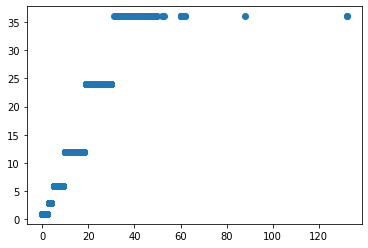

In [117]:
plt.scatter(df_A['months'], df_A['rebill_months'])

## Grouping the dataframe by rebill_months

In [118]:
# drop what we dont need
df_A.drop(columns = ['start_date', 'end_date', 'month_interval', 'months'], axis=1, inplace=True)

In [119]:
df_A.head()

currency        BU   period   amount  rebill_months
0      AUD  Creative  2015-06  8003.00            1.0
1      AUD  Creative  2015-06  7040.51            1.0
2      AUD  Creative  2015-06  8087.82            1.0
3      AUD  Creative  2015-06  8212.77            1.0
4      AUD  Creative  2015-06  6452.47            1.0

In [265]:
#gb_A = df+A.groupby(['curr', 'BU', 'period'], as_index=False).sum()

255408

In [120]:
#medals = df.pivot_table('no of medals', ['Year', 'Country'], 'medal')
temp = df_A.pivot_table('amount', ['currency', 'BU', 'period'], 'rebill_months')

In [121]:
temp

rebill_months                                1.0          3.0        6.0   \
currency BU                 period                                          
AUD      Creative           2015-06   7410.857222      412.730        NaN   
                            2015-08   7284.192982      257.045        NaN   
                            2015-09   7122.768056          NaN        NaN   
                            2015-10   6726.175517      128.180        NaN   
                            2015-11   6896.387241      450.000        NaN   
...                                           ...          ...        ...   
USD      Print & Publishing 2018-11  35892.827586  2153161.715        NaN   
                            2018-12  25516.156765          NaN  249999.99   
                            2019-01   2867.777778          NaN        NaN   
                            2019-02  14035.777619          NaN        NaN   
                            2019-03   2515.806452          NaN        NaN   

rebill_months                                12.0        24.0  36.0  
currency BU                 period                                   
AUD      Creative           2015-06   4954.487778  608.377500   NaN  
                            2015-08   5985.608103  648.305882   NaN  
                            2015-09   5801.415278  741.312857   NaN  
                            2015-10   5229.060000  597.380000   NaN  
                            2015-11   5751.434138  672.630769   NaN  
...                                           ...         ...   ...  
USD      Print & Publishing 2018-11  73684.812105         NaN   NaN  
                            2018-12  81120.952381         NaN   NaN  
                            2019-01   3615.000000         NaN   NaN  
                            2019-02  34180.769231         NaN   NaN  
                            2019-03   2179.285714         NaN   NaN  

[1207 rows x 6 columns]

In [122]:
temp.columns[5]

36.0

In [123]:
temp.fillna(0)

rebill_months                                1.0          3.0        6.0   \
currency BU                 period                                          
AUD      Creative           2015-06   7410.857222      412.730       0.00   
                            2015-08   7284.192982      257.045       0.00   
                            2015-09   7122.768056        0.000       0.00   
                            2015-10   6726.175517      128.180       0.00   
                            2015-11   6896.387241      450.000       0.00   
...                                           ...          ...        ...   
USD      Print & Publishing 2018-11  35892.827586  2153161.715       0.00   
                            2018-12  25516.156765        0.000  249999.99   
                            2019-01   2867.777778        0.000       0.00   
                            2019-02  14035.777619        0.000       0.00   
                            2019-03   2515.806452        0.000       0.00   

rebill_months                                12.0        24.0  36.0  
currency BU                 period                                   
AUD      Creative           2015-06   4954.487778  608.377500   0.0  
                            2015-08   5985.608103  648.305882   0.0  
                            2015-09   5801.415278  741.312857   0.0  
                            2015-10   5229.060000  597.380000   0.0  
                            2015-11   5751.434138  672.630769   0.0  
...                                           ...         ...   ...  
USD      Print & Publishing 2018-11  73684.812105    0.000000   0.0  
                            2018-12  81120.952381    0.000000   0.0  
                            2019-01   3615.000000    0.000000   0.0  
                            2019-02  34180.769231    0.000000   0.0  
                            2019-03   2179.285714    0.000000   0.0  

[1207 rows x 6 columns]

In [124]:
temp.rename(index=str, columns = {''})

TypeError: 'set' object is not callable

In [300]:
whos

Variable               Type         Data/Info
---------------------------------------------
ZCC_curr               ndarray      11: 11 elems, type `object`, 88 bytes
ZCC_isna               Series       0        True\n1       Fa<...>Length: 4697, dtype: bool
a                      int          0
add_ZCC_periods        function     <function add_ZCC_periods at 0x10cb4b400>
clean_df_columns       function     <function clean_df_columns at 0x10cb4b0d0>
config_list            list         n=4
df                     DataFrame         curr                <...>n[3970 rows x 13 columns]
df_A                   DataFrame           currency          <...>[255408 rows x 5 columns]
df_cal                 DataFrame         Year  Quarter  Perio<...>n\n[252 rows x 9 columns]
gb_ZCC                 DataFrame         curr                <...>\n[1824 rows x 5 columns]
gb_ZCC_annual          DataFrame         curr                <...>n\n[887 rows x 5 columns]
gb_ZCC_four_mths       DataFrame    Empty DataF